# TWM Praktikum 5
#### Wintersemester 2019/2020 (Prof. Dr. Markus Döhring, Dr. Steffen Schnitzer, Nina Krüger)

%%bash
# NUR bei RosettaHub ändern: Cell>CellType>Code
for K in $(apt-key list | grep expired | cut -d'/' -f2 | cut -d' ' -f1); do sudo apt-key adv --recv-keys --keyserver keys.gnupg.net $K; done
sudo cat > /etc/apt/sources.list << EOF
deb http://archive.ubuntu.com/ubuntu xenial main restricted universe multiverse
deb-src http://archive.ubuntu.com/ubuntu xenial main restricted universe multiverse
deb http://archive.ubuntu.com/ubuntu xenial-updates main restricted universe multiverse
deb-src http://archive.ubuntu.com/ubuntu xenial-updates main restricted universe multiverse
deb http://archive.ubuntu.com/ubuntu xenial-backports main restricted universe multiverse
deb-src http://archive.ubuntu.com/ubuntu xenial-backports main restricted universe multiverse
deb http://archive.ubuntu.com/ubuntu xenial-security main restricted universe multiverse
deb-src http://archive.ubuntu.com/ubuntu xenial-security main restricted universe multiverse
#deb http://archive.ubuntu.com/ubuntu xenial-proposed restricted main universe multiverse
#deb-src http://archive.ubuntu.com/ubuntu xenial-proposed restricted main universe multiverse
deb http://archive.canonical.com/ubuntu xenial partner
deb-src http://archive.canonical.com/ubuntu xenial partner
EOF
sudo apt-get -y install graphviz

In [0]:
import sys
if 1==0: #ändern in 1==1, falls auf RosettaHub ausgeführt
    !{sys.executable} -m pip install --upgrade tensorflow-gpu
    !{sys.executable} -m pip install  nltk
    !{sys.executable} -m pip install  sklearn
    !{sys.executable} -m pip install pydotplus
    !{sys.executable} -m pip install  graphviz
    !{sys.executable} -m pip install  --upgrade keras
    !{sys.executable} -m pip install --upgrade tensorflow

In [0]:
import sys
if 1==0: #ändern in 1==1, falls auf TWM ausgeführt
    !{sys.executable} -m pip install --ignore-installed --upgrade tensorflow-gpu
    !{sys.executable} -m pip install --ignore-installed nltk
    !{sys.executable} -m pip install --ignore-installed sklearn
    !{sys.executable} -m pip install --ignore-installed pydotplus
    !{sys.executable} -m pip install --ignore-installed graphviz
    !{sys.executable} -m pip install --ignore-installed --upgrade keras
    !{sys.executable} -m pip install --ignore-installed --upgrade tensorflow
    !{sys.executable} -m pip uninstall -y numpy
    !{sys.executable} -m pip uninstall -y numpy
    !{sys.executable} -m pip uninstall -y numpy
    !{sys.executable} -m pip install --upgrade numpy

In [1]:
#imports und keras/tensorflow Einstellungen für Reproduzierbarkeit
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(2)
tf.set_random_seed(3)

import keras
keras.__version__
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.externals.six import StringIO  
from IPython.display import Image, display  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from keras.datasets import imdb

import json
import numpy
import nltk

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import imdb
from keras.preprocessing import sequence

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:
#wir setzen eine globalen Parameter für die maximale Länge von Reviews.
#Alle Reviews, die länger als review_length Wörter sind, werden vor der Modellbildung entsprechend gekürzt 
review_length = 500

#ein weiterer globaler Parameter gibt an, wie groß das Dictionnary sein darf.
#Es werden grundsätzlich die nwords am häufigsten im Corpus vorkommenden Wörter verwendet. 
nwords = 10000


Hinweis: ein Großteil dieses Notebooks basiert auf dem Buch "Deep Learning with Python" (Chollet 2017), insbesondere Kapitel 6, und entsprechend bereitgestelltem Code: https://github.com/fchollet/deep-learning-with-python-notebooks


## 1. IMDB Movie Reviews - Explorative Datenanalyse

In Praktikum 5 arbeiten wir mit dem IMDB Datensatz, der durch Keras bereitgestellt wird. Dieser enthält insgesamt 50.000 stark positiv/negativ geprägte Reviews. Der folgende Python Code liefert 25.000 Reviews (X\_ Arrays) mit entsprechenden Labels (Y\_ Arrays) für das Training und 25.000 Reviews für das Testen eines Modells. 

In [3]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=nwords)

17465344/17464789 [==============================] - 2s 0us/step


Die von Keras bereitgestellten Datenstrukturen bestehen aus Arrays von Ganzzahlen, die Einträge in einem Lexikon darstellen. Um uns Texte anschauen (oder ggf. textuell weiterverarbeiten) zu können, müssen wir diese "zurückübersetzen", d.h. die Ganzzahlen wieder in Wörter transformieren. Weiterhin kürzen wir die Reviews auf eine in den globelen Parmetern gesetzte Länge. 

In [0]:
# word_index ist ein dictionnary, das Wörter auf eine Ganzzahl abbildet
word_index = imdb.get_word_index()
# wir kehren den Word Index um und bilden nun Ganzzahlen auf Wörter ab
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Wir dekodieren die Reviews. Achtung: Die Indizes sind um 3 verschoben
# weil 0, 1 and 2 reservierte Indizes für "padding", "start of sequence" und "unknown" sind
X_train = [sequence[0:min(review_length,len(sequence))] for sequence in X_train]
X_test = [sequence[0:min(review_length,len(sequence))] for sequence in X_test]
X_train = [
    ' '.join(
        reverse_word_index.get(i - 3, '?')
        for i in X_train[i]
        if i < len(reverse_word_index)
    ) for i in range(len(X_train))
]

X_test = [
    ' '.join(
        reverse_word_index.get(i - 3, '?')
        for i in X_test[i]
        if i < len(reverse_word_index)
    ) for i in range(len(X_test))
]

### Aufgabe 1: Schauen Sie sich einige Reviews und deren Labels an
Ist ein Datensatz mit 1 gelabelt, dann steht dies fuer einen eher positives Review. Die 0 als Label steht fuer ein eher negatives Review.

In [32]:
print('Training entries: ' + str(len(X_train)) + ' Labels: ' + str(len(y_test)))

for i in range(10):
  print('Label: ' + str(y_train[i]) + ' Text: ' + str(X_train[i]))

Training entries: 25000 Labels: 25000
Label: 1 Text: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

**Antwort:** Die Betrachtung der ersten zehn Review-Texte hat gezeigt, dass die Labels sehr gut für die einzelnen Reviews gewählt wurden. 

### Aufgabe 2: Identifizieren Sie die relevantesten Features (Wörter) anhand des Chi²-Wertes

In [65]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True,stop_words='english')
X = vectorizer.fit_transform(X_train)

from sklearn.feature_selection import chi2
results = vectorizer.get_feature_names()
chi2score = chi2(X,y_train)[0]
words_chi2 = np.argsort(chi2score)

counter = -1
while (counter > -11):
  number = words_chi2[counter]
  print(results[number])
  counter = counter -1

bad
worst
great
awful
waste
terrible
movie
excellent
stupid
worse


### Aufgabe 3: Prüfen und begründen Sie, ob „accuracy“ ein sinnvolles Gütemaß für einen Klassifikator auf diesem Datensatz ist.  

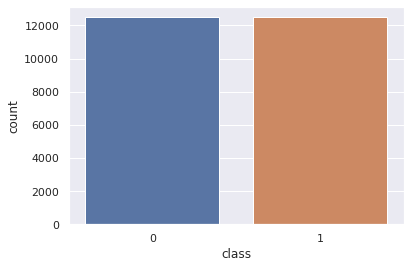

In [97]:
%matplotlib inline
import seaborn as sns
unique, counts = numpy.unique(y_train, return_counts=True)
count_labels = pd.DataFrame(zip(unique, counts))
count_labels.columns = ['class', 'count']
sns.barplot(x='class', y='count', data=count_labels)

**Begründung:**   
Formel:    
<a target="_blank"><img src="https://latex.codecogs.com/png.latex?\dpi{107}&space;Accuracy&space;=&space;\frac{TP&space;&plus;&space;TN}{TP&plus;FP&plus;FN&plus;TN}" title="Accuracy = \frac{TP + TN}{TP+FP+FN+TN}" /></a>

Der Plot zeigt, dass die beiden Klassen (0 und 1) die gleiche Anzahl von Review-Texten enthalten. Die Fehlermetrik Accuracy kann vor allem auf balancierten Datensätzen aussagekräftig eingesetzt werden, dies trifft bei diesem Datensatz zu. 

## 2. Deep Learning
### 2.1. RNN mit Embeddings


Im folgenden lernen wir ein RNN mit Embeddings Layer über 10 Iterationen (Epochen). Für jede Epoche wird die Performance (accuracy) für die Trainings- und die Validierungsdaten (20%, die vom ursprünglichen Trainingsdatensatz nochmal beiseite gelegt wurdden) ausgegeben. Am Ende werden die entsprechenden Werte im Zeitverlauf graphisch dargestellt. 

In [8]:
from keras.preprocessing import sequence


print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=nwords)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=review_length)
input_test = sequence.pad_sequences(input_test, maxlen=review_length)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [9]:
%%time
from keras.layers import Dense
import keras 
#tbCallBack = keras.callbacks.TensorBoard(log_dir='/home/student/PycharmProjects/test/logs/', histogram_freq=0, write_graph=True, write_images=True)
model = Sequential()
model.add(Embedding(nwords, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2#,
                     #callbacks=[tbCallBack]
                   )            






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 5000 samples
Epoch 1/10




20000/20000 [==============================] - 19s 934us/step - loss: 0.6148 - acc: 0.6476 - val_loss: 0.5091 - val_acc: 0.7676
Epoch 2/10
20000/20000 [==============================] - 18s 893us/step - loss: 0.3813 - acc: 0.8406 - val_loss: 0.4616 - val_acc: 0.7854
Epoch 3/10
20000/20000 [==============================] - 18s 900us/step - loss: 0.2875 - acc: 0.8865 - val_loss: 0.4010 - val_acc: 0.8186
Epoch 4/10
20000/20000 [==============================] - 18s 896us/step - loss: 0.2211 - acc: 0.9172 - val_loss: 0.4880 - val_acc: 0.7672
Epoch 5/10
20000/20000 [==============================] - 18s 896us/step - loss: 0.1642 - acc: 0.9405 - val_loss: 0.3963 - val_acc: 0.8592
Epoch 6/10
20000/20000 [==============================] - 18s 897us/step - loss: 0.1149 - acc: 0.9598 - val_loss: 0.4490 - val_acc: 0.8282
Epoch 7/10
20

In [0]:
def plothist(hist):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()


    plt.show()
    

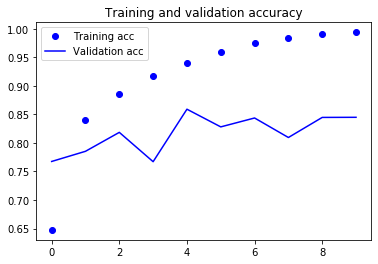

In [11]:
plothist(history)


### Aufgabe 4: Wie interpretieren Sie die Performance-Kurven zum RNN bzw. was fällt Ihnen auf?

IHRE INTERPRETATION HIER

Basierend auf der Train-Validation Performance entscheiden wir, unser Modell auf den gesamten Trainingsdaten über 4 Epochen zu trainieren. Dann geben wir die Performance auf den Testdaten aus. 

In [12]:
model.reset_states()

model.fit(input_train, y_train, epochs=2, batch_size=128)
results = model.evaluate(input_test, y_test)
results[1]



Epoch 1/2
25000/25000 [==============================] - 21s 839us/step - loss: 0.1467 - acc: 0.9540
Epoch 2/2
25000/25000 [==============================] - 12s 486us/step


0.8114

### Aufgabe 5: Schauen Sie sich einige der "drastischsten" false positives und false negatives an (hohe Score und Label=1 oder niedrige Score und Label=0). Können Sie erahnen, was das Modell ggf. verwirrt hat?

In [0]:
#IHR CODE+BEGRÜNDUNG HIER

### 2.2 RNN mit Glove 50 Layer

Nun trainieren wir ein RNN mit der selben Architektur wie vorher, nur dass wir anstelle eines parallel trainierten 32-dimensionalen Embeddings ein 50-dimensionales, vortrainiertes Word-Embedding verwenden.

In [14]:
import os
import numpy as np
from io import BytesIO
from zipfile import ZipFile
import requests

embeddings_index = {}

glove6B = 'glove.6B.50d.txt'

if os.path.isfile(glove6B):
    print('Glove tokens file already exists. No need to download it.')
    f = open(glove6B)
else:
    print('Glove tokens file does not exists. Download can take some time.')
    url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    resp = requests.get(url)
    zipfile = ZipFile(BytesIO(resp.content))
    f = zipfile.open(glove6B)
    #saving it for the next run
    zipfile.extract(glove6B)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

from keras.datasets import imdb
embedding_dim = 50
word_index = imdb.get_word_index()
embedding_matrix = np.zeros((nwords, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < nwords:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Glove tokens file does not exists. Download can take some time.
Found 400000 word vectors.


In [15]:
%%time
model = Sequential()
model.add(Embedding(nwords, 50))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2#,
                     #callbacks=[tbCallBack]
                   )            


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 17s 855us/step - loss: 0.6947 - acc: 0.5010 - val_loss: 0.6937 - val_acc: 0.4938
Epoch 2/10
20000/20000 [==============================] - 17s 846us/step - loss: 0.6942 - acc: 0.5032 - val_loss: 0.6933 - val_acc: 0.4938
Epoch 3/10
20000/20000 [==============================] - 17s 842us/step - loss: 0.6944 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 4/10
20000/20000 [==============================] - 17s 846us/step - loss: 0.6933 - acc: 0.5001 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 5/10
20000/20000 [==============================] - 17s 848us/step - loss: 0.6950 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 6/10
20000/20000 [==============================] - 17s 852us/step - loss: 0.6933 - acc: 0.4936 - val_loss: 0.6932 - val_acc: 0.4938
Epoch 7/10
20000/20000 [==============================] - 17s 856us/step - loss: 0.6932 - acc: 0.4948 - val_loss: 0.6

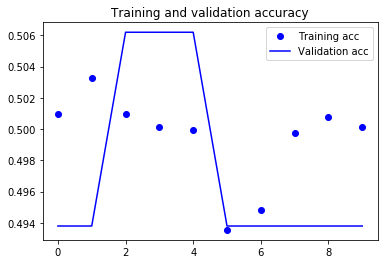

In [16]:
plothist(history)


In [17]:
model.reset_states()
model.fit(input_train, y_train, epochs=3, batch_size=128)
results = model.evaluate(input_test, y_test)
results

Epoch 1/3
25000/25000 [==============================] - 20s 780us/step - loss: 0.6937 - acc: 0.5026
Epoch 2/3
25000/25000 [==============================] - 19s 761us/step - loss: 0.6937 - acc: 0.5016
Epoch 3/3
25000/25000 [==============================] - 14s 555us/step


[0.6933911445808411, 0.5]

### Aufgabe 6: Optional (nur wenn Sie gut in der Zeit liegen und fit in der Materie sind!): Wie interpretieren Sie die Performance-Kurven und Ergebnisse auf den Testdaten zum RNN mit vorgelernten Glove-Embedding bzw. was fällt Ihnen auf

IHRE INTERPRETATION HIER

### 2.3 LSTM

Nun trainieren wir anstatt eines Modells mit normalen RNN Zellen ein Modell mit LSTM Zellen. Ansonsten bleiben alle anderen Rahmenbedingungen identisch zum Modell unter 2.1

In [18]:
%%time 
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(nwords, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 79s 4ms/step - loss: 0.5657 - acc: 0.7240 - val_loss: 0.4002 - val_acc: 0.8354
Epoch 2/10
20000/20000 [==============================] - 77s 4ms/step - loss: 0.3200 - acc: 0.8687 - val_loss: 0.8985 - val_acc: 0.6932
Epoch 3/10
20000/20000 [==============================] - 77s 4ms/step - loss: 0.2451 - acc: 0.9073 - val_loss: 0.3015 - val_acc: 0.8766
Epoch 4/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.2084 - acc: 0.9216 - val_loss: 0.3693 - val_acc: 0.8574
Epoch 5/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.1861 - acc: 0.9320 - val_loss: 0.2993 - val_acc: 0.8868
Epoch 6/10
20000/20000 [==============================] - 77s 4ms/step - loss: 0.1637 - acc: 0.9426 - val_loss: 0.3331 - val_acc: 0.8574
Epoch 7/10
20000/20000 [==============================] - 77s 4ms/step - loss: 0.1492 - acc: 0.9467 - val_loss: 0.3278 - val_acc:

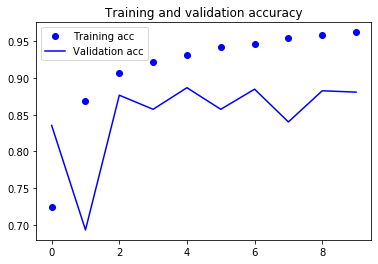

In [19]:
plothist(history)

In [20]:
model.reset_states()
model.fit(input_train, y_train, epochs=4, batch_size=128)
results = model.evaluate(input_test, y_test)
results

Epoch 1/4
25000/25000 [==============================] - 93s 4ms/step - loss: 0.1632 - acc: 0.9442
Epoch 2/4
25000/25000 [==============================] - 93s 4ms/step - loss: 0.1425 - acc: 0.9509
Epoch 3/4
25000/25000 [==============================] - 92s 4ms/step - loss: 0.1311 - acc: 0.9553
Epoch 4/4
25000/25000 [==============================] - 30s 1ms/step


[0.40798432788848876, 0.86404]

### Aufgabe 7: Wie interpretieren Sie die Performance-Kurven und Ergebnisse auf den Testdaten zum LSTM bzw. was fällt Ihnen auf?

IHRE INTERPRETATION HIER

## 3. Not So Deep Learning

Im folgenden verwenden wir sehr einfache Klassifikationsmodelle: Eine logistische Regression (siehe ggf. Wikipedia o.ä.) und einen Decision Tree aufbauend auf TF-IDF gewichteten Unigrammen+Bigrammen. 

## Logistische Regression

In [21]:
%%time
model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('log', LogisticRegression())
])

model.fit(X_train, y_train)

CPU times: user 30 s, sys: 9.35 s, total: 39.4 s
Wall time: 27.6 s


In [22]:
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))
print((y_pred == y_test).mean())

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     12319
           1       0.89      0.88      0.89     12681

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

0.88588


In [23]:
# Ausgabe der Features sortiert nach ihren Koeffizienten innerhalb des LogReg Modells
np.array(model.named_steps['tfidf'].get_feature_names())[np.argsort(model.named_steps['log'].coef_[0])]

array(['bad', 'worst', 'the worst', ..., 'and', 'excellent', 'great'],
      dtype='<U31')

## Decision Tree

In [24]:
%%time
model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('tree', DecisionTreeClassifier(criterion='gini', max_depth=4))
])

model.fit(X_train, y_train)

CPU times: user 23.3 s, sys: 70.5 ms, total: 23.4 s
Wall time: 23.4 s


In [25]:
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))
print((y_pred == y_test).mean())

              precision    recall  f1-score   support

           0       0.48      0.83      0.61      7233
           1       0.90      0.63      0.74     17767

    accuracy                           0.69     25000
   macro avg       0.69      0.73      0.68     25000
weighted avg       0.78      0.69      0.71     25000

0.69124


In [26]:
dot_data = StringIO()

export_graphviz(model.named_steps['tree'], out_file=dot_data, filled=True, rounded=True, special_characters=True)

splitArgs = model.named_steps['tree'].tree_.feature.tolist()

dot_data = dot_data.getvalue()

print('Das sind die Splitargumente des DecisionTrees:')

for x in ([arg for arg in splitArgs if arg != -2 ]):
    rep = model.named_steps['tfidf'].get_feature_names()[x] 
    dot_data = dot_data.replace('X<SUB>'+str(x)+'</SUB>', str(rep))
    print(rep)

Das sind die Splitargumente des DecisionTrees:
bad
worst
waste
awful
city
worst
beautiful
incredible
great
worst
bad
excellent
worst
bad
out


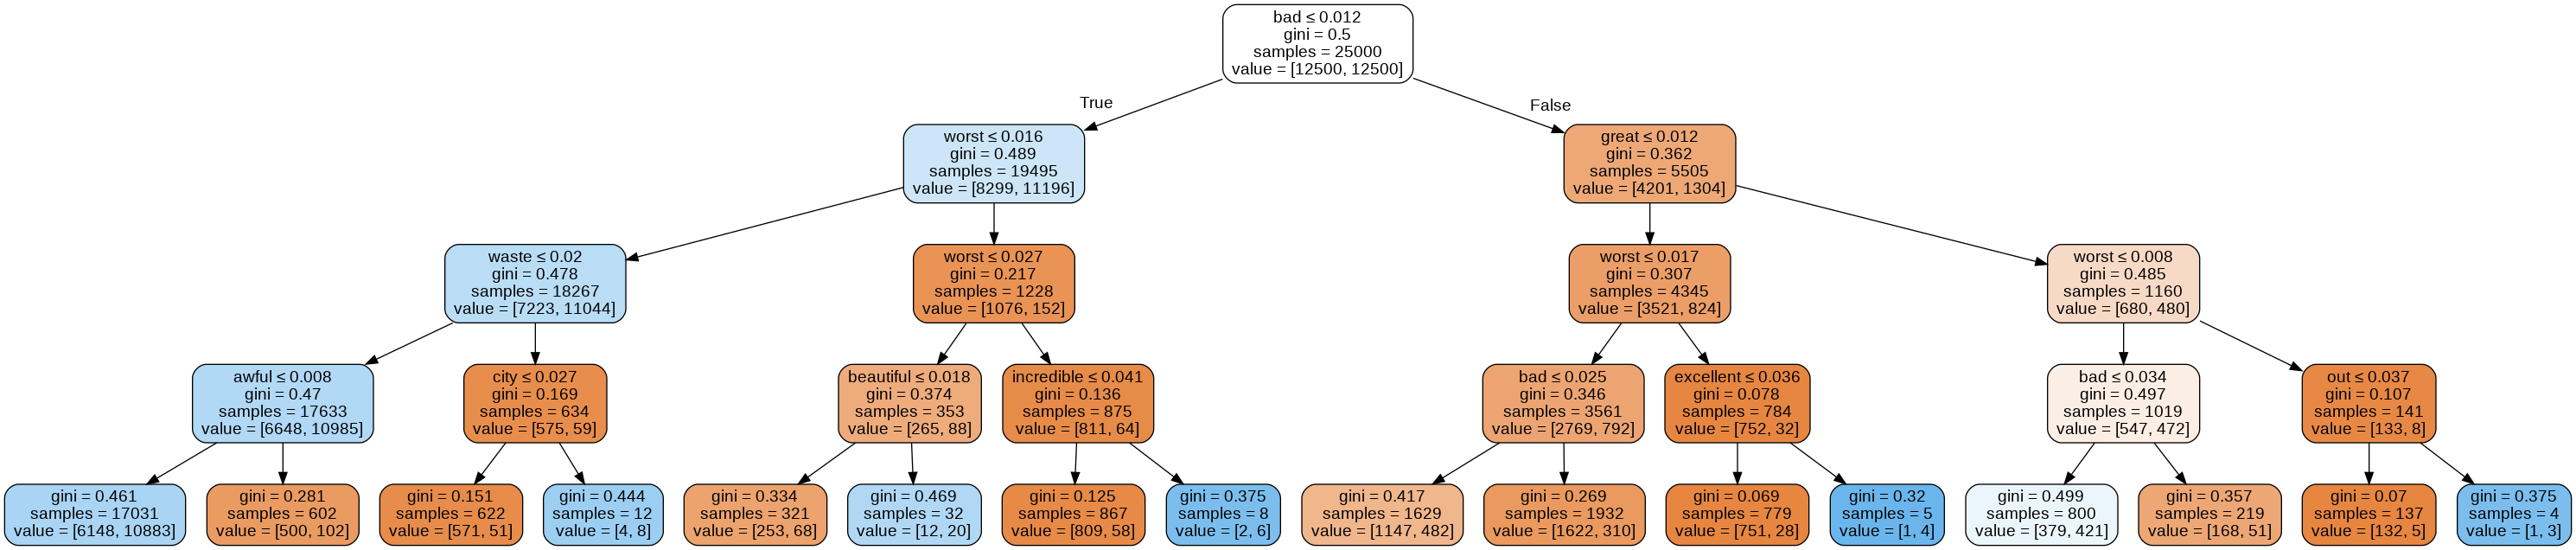

In [27]:
%matplotlib notebook
# Falls Sie https://www.graphviz.org/ installiert haben, koennen Sie den Decision Tree auch plotten
# In der twm VM koennen Sie graphviz mit: sudo apt-get -y install graphviz
# installieren
try:
    graph = pydotplus.graph_from_dot_data(dot_data)
    display(Image(graph.create_png()))
except:
    print('graphviz ist nicht installiert')

### Aufgabe 8: Wie interpretieren Sie die Ergebnisse der "einfacheren" Klassifikationsmodelle auf den Testdaten bzw. was fällt Ihnen auf? Inwiefern deckt sich die Wichtigkeit der Features mit der, die Sie in Aufgabe (2) ermittelt haben?

IHRE INTERPRETATION HIER